In [8]:
from lda2vec import preprocess, Corpus
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
%matplotlib inline

In [2]:
import pyLDAvis
pyLDAvis.enable_notebook()

In [3]:
import warnings
warnings.simplefilter('ignore');

/home/james/src/topic_modeling/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Load messages.

In [4]:
messages = pd.read_csv('../data/messages_100k.csv')
messages = messages['message'].tolist()

Load saved model topics.

In [5]:
npz = np.load(open('../topic_modeling/lda2vec/results/topics.3.pyldavis.npz', 'rb'))
dat = {k: v for (k, v) in npz.iteritems()}
dat['vocab'] = dat['vocab'].tolist()
# dat['term_frequency'] = dat['term_frequency'] * 1.0 / dat['term_frequency'].sum()

In [12]:
dat.keys()

dict_keys(['topic_term_dists', 'doc_topic_dists', 'doc_lengths', 'vocab', 'term_frequency'])

Get BERT embeddings.

In [6]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(messages, show_progress_bar=True)

Visualize BERT features in 2D.

In [9]:
umap_data_2d = umap.UMAP(
    n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [10]:
result = pd.DataFrame(umap_data_2d, columns=['x', 'y'])

In [11]:
result.head()

x         y
0   8.958838  9.560543
1  11.215785  5.435351
2  10.401687  7.361381
3   9.864329  9.617056
4   6.415185  2.477155

In [38]:
n_docs, n_topics = dat['doc_topic_dists'].shape

In [33]:
confidence = 0.8

In [34]:
row_idx, col_idx = (dat['doc_topic_dists'] >= confidence).nonzero()

In [40]:
labels = np.ones(n_docs) * -1

In [44]:
num_docs_per_topic = []
for i in range(n_topics):
    doc_idx = row_idx[col_idx == i]
    labels[doc_idx] = i
    num_docs_per_topic.append(len(doc_idx))

In [45]:
num_docs_per_topic

[5910,
 5783,
 5975,
 5926,
 6051,
 4609,
 5969,
 3229,
 5465,
 4460,
 3422,
 3769,
 5886,
 5984,
 4464]

In [46]:
result['labels'] = labels

In [47]:
result.head()

x         y  labels
0   8.958838  9.560543     9.0
1  11.215785  5.435351    11.0
2  10.401687  7.361381    10.0
3   9.864329  9.617056    11.0
4   6.415185  2.477155     6.0

In [49]:
topics = range(n_topics)

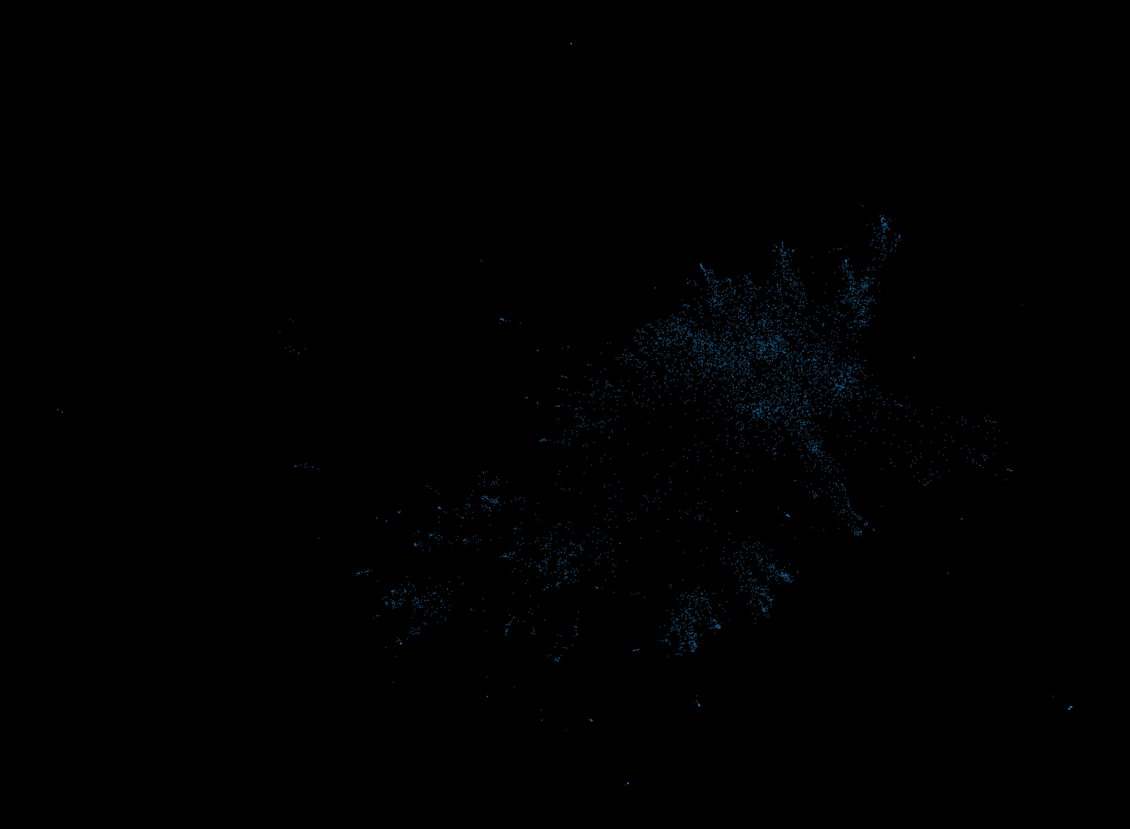

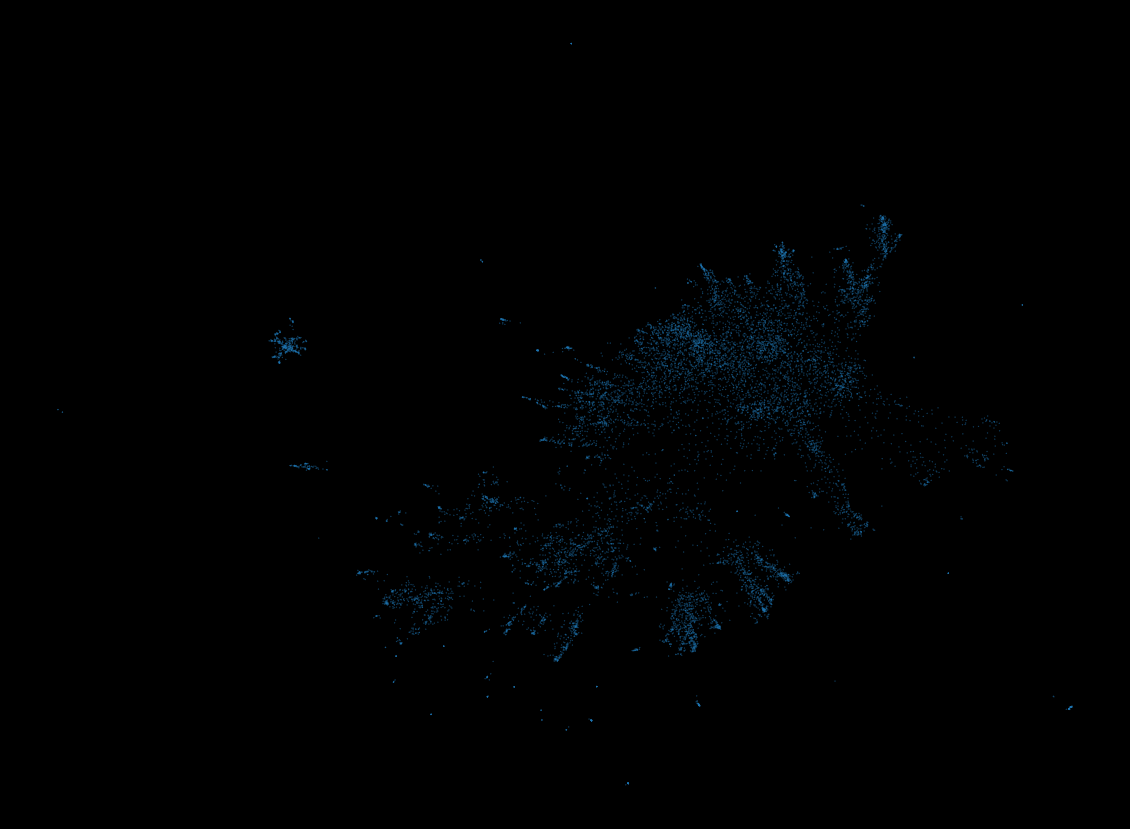

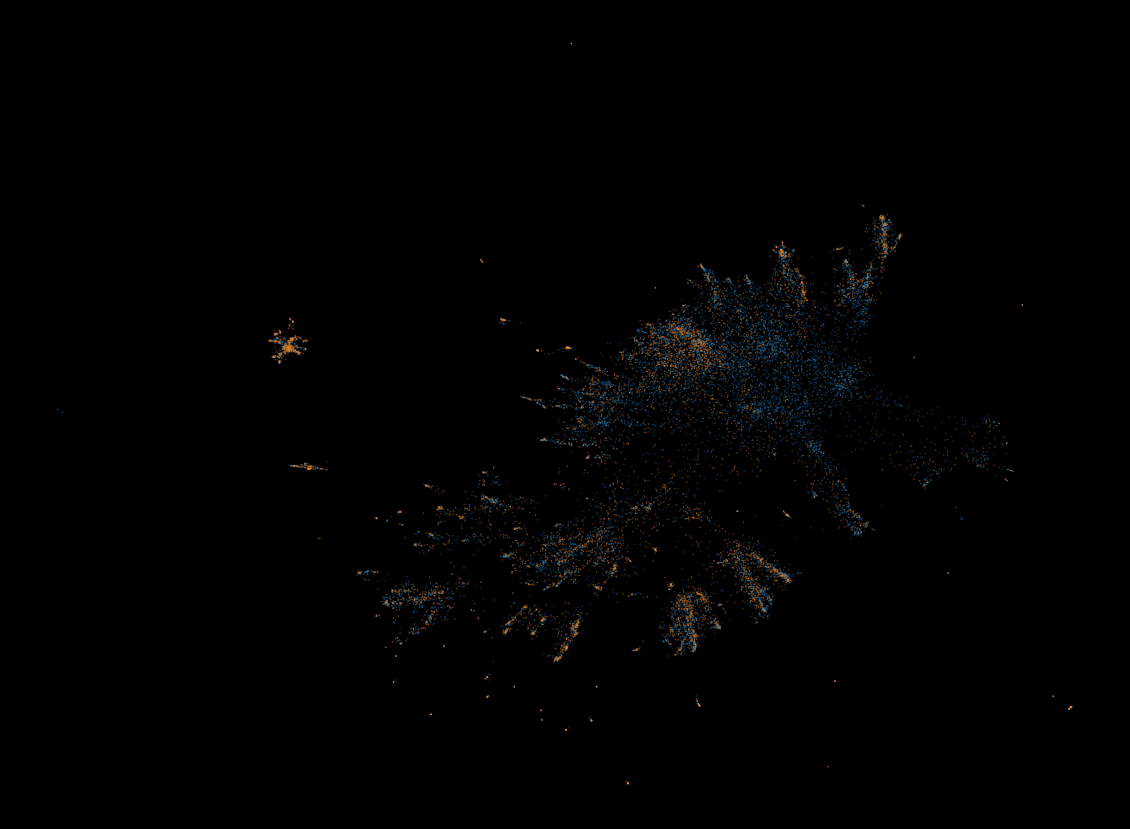

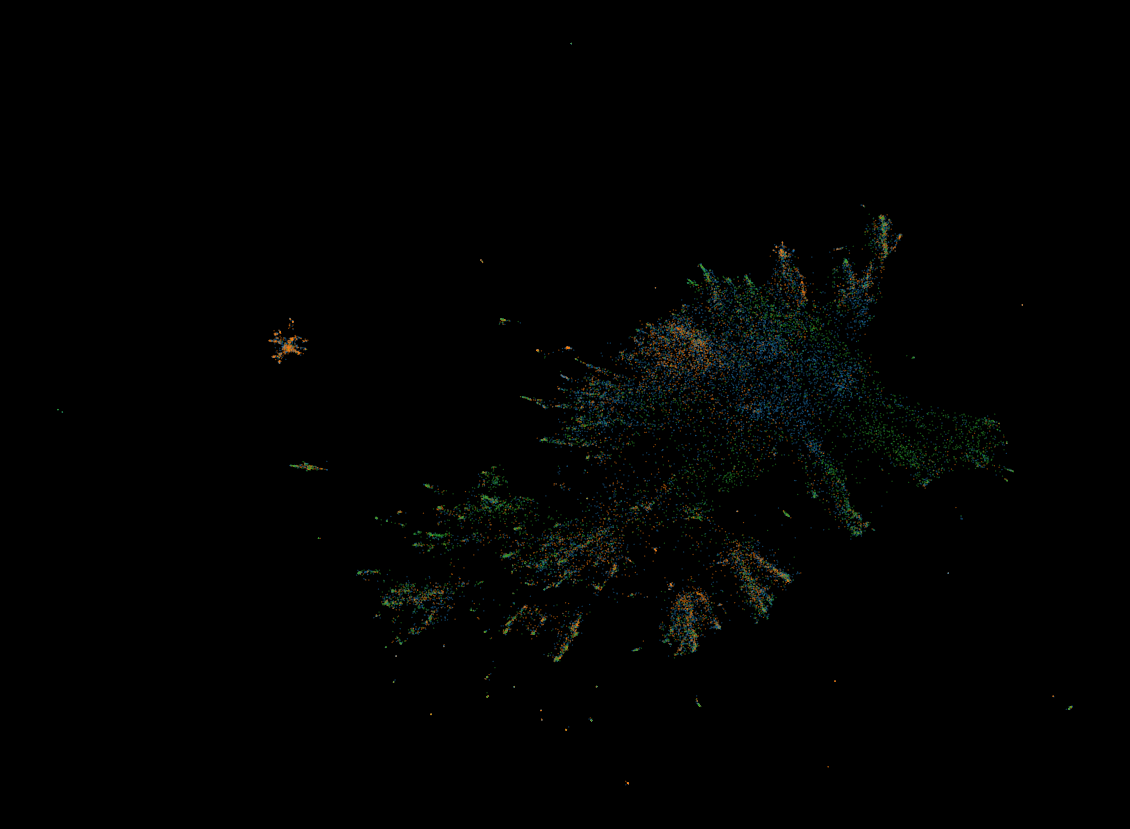

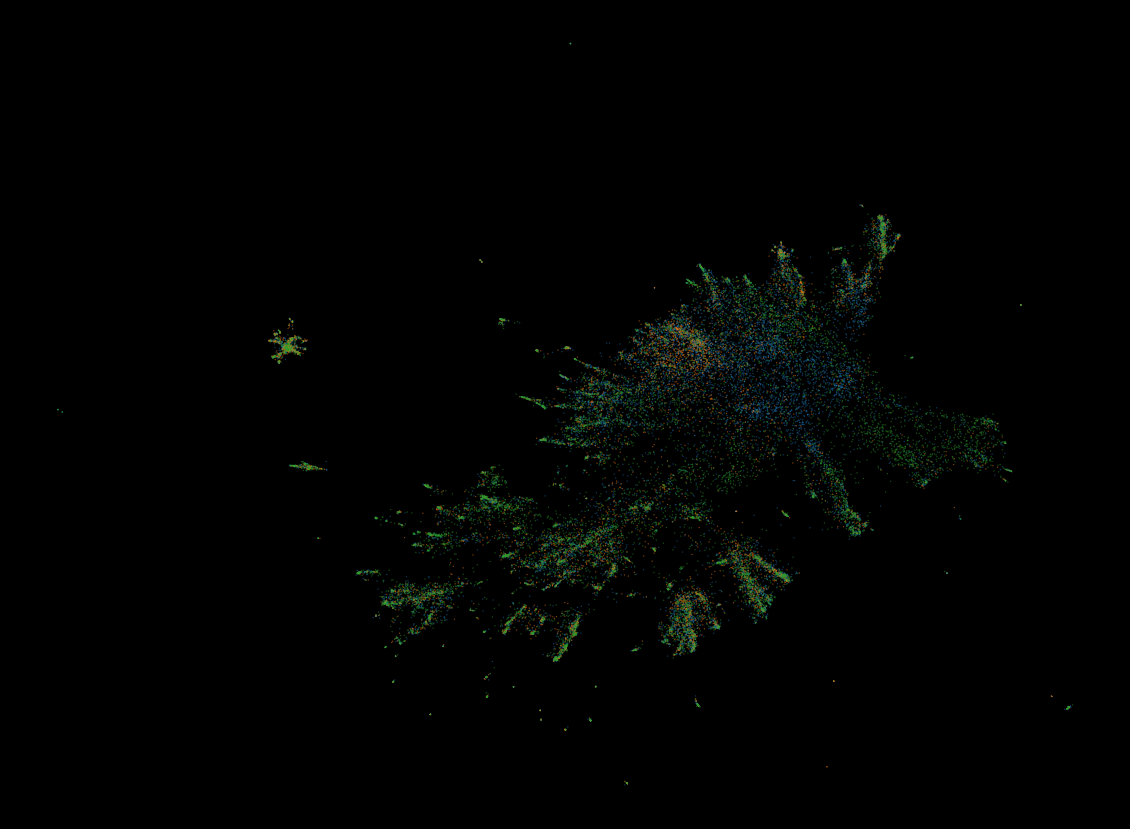

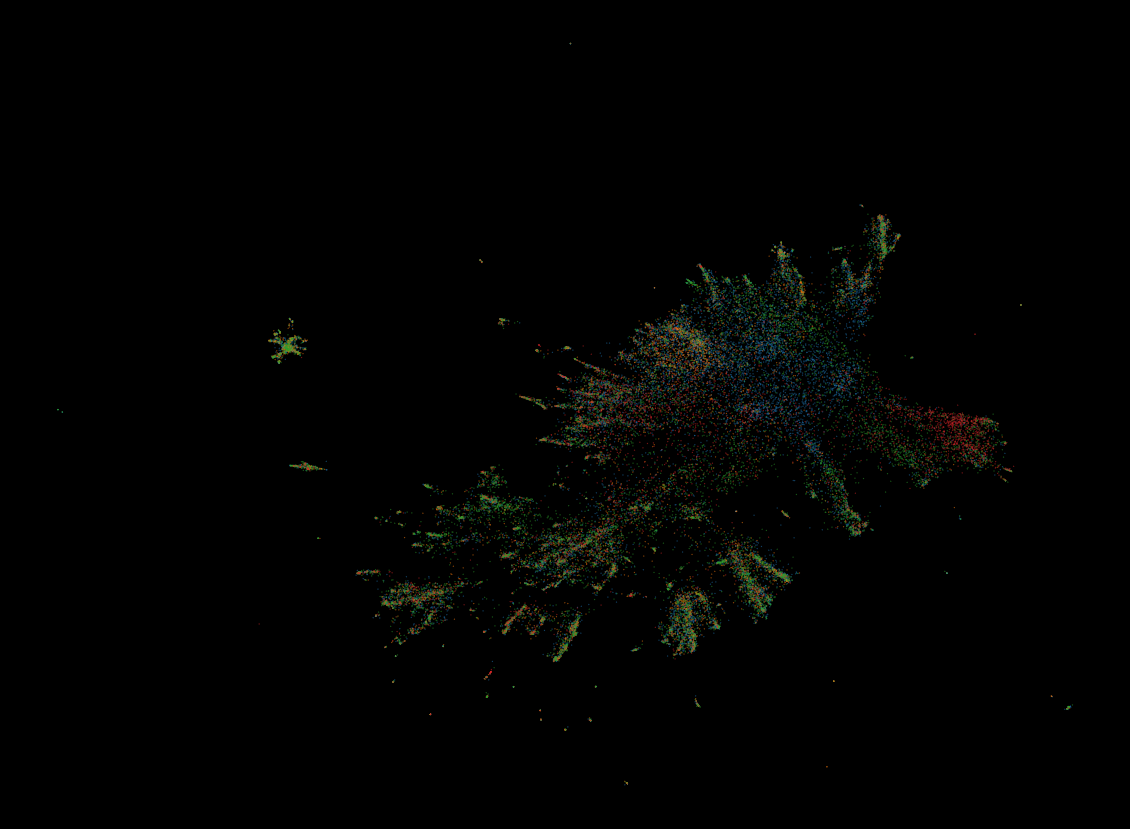

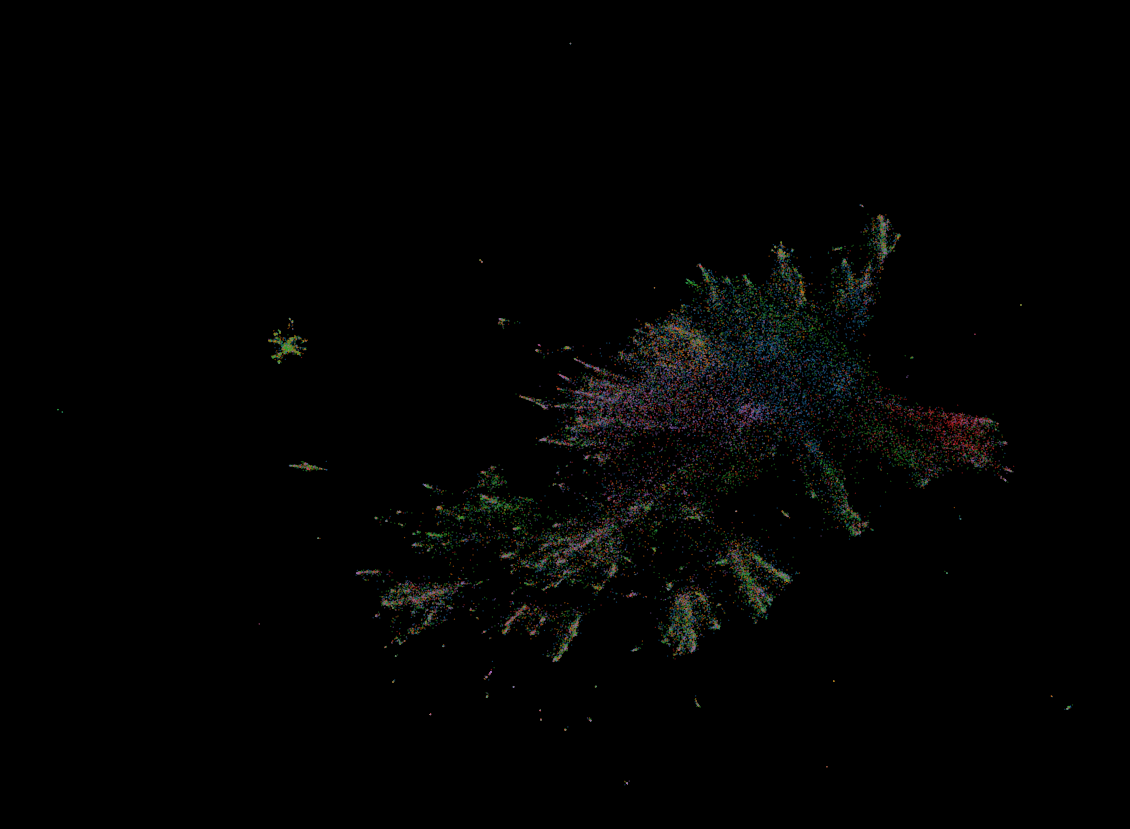

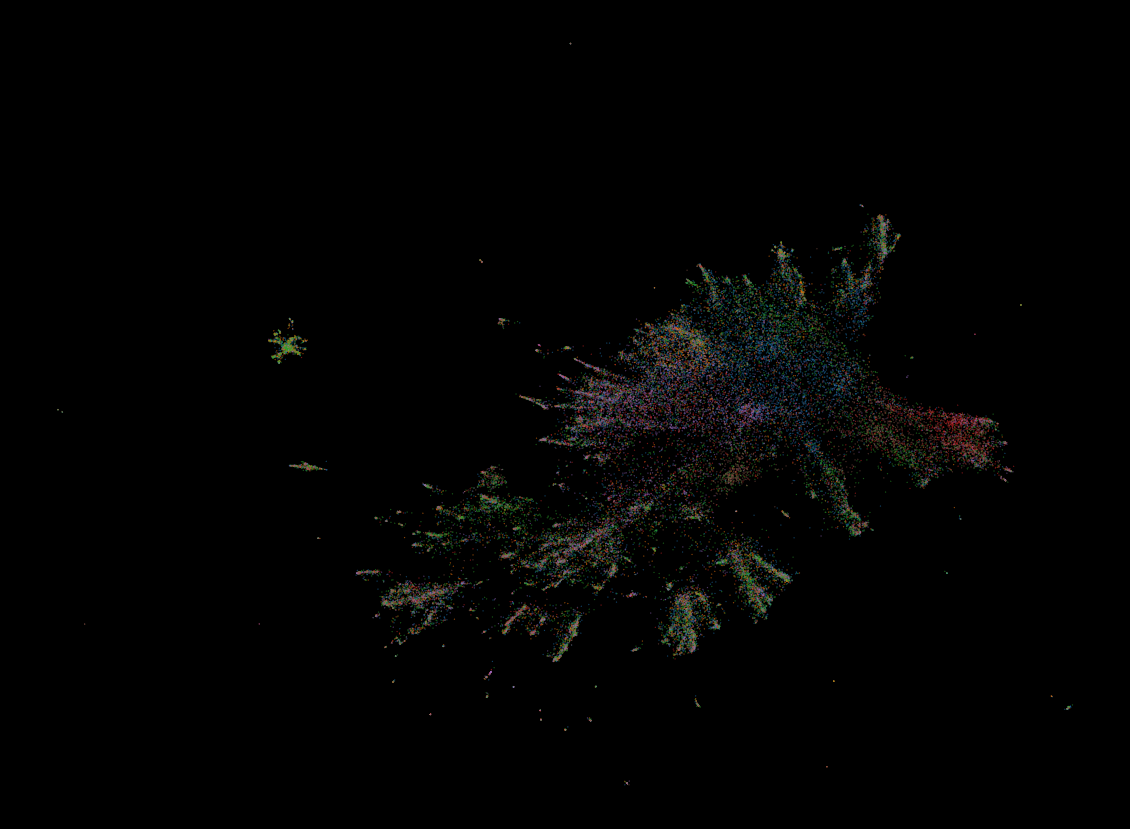

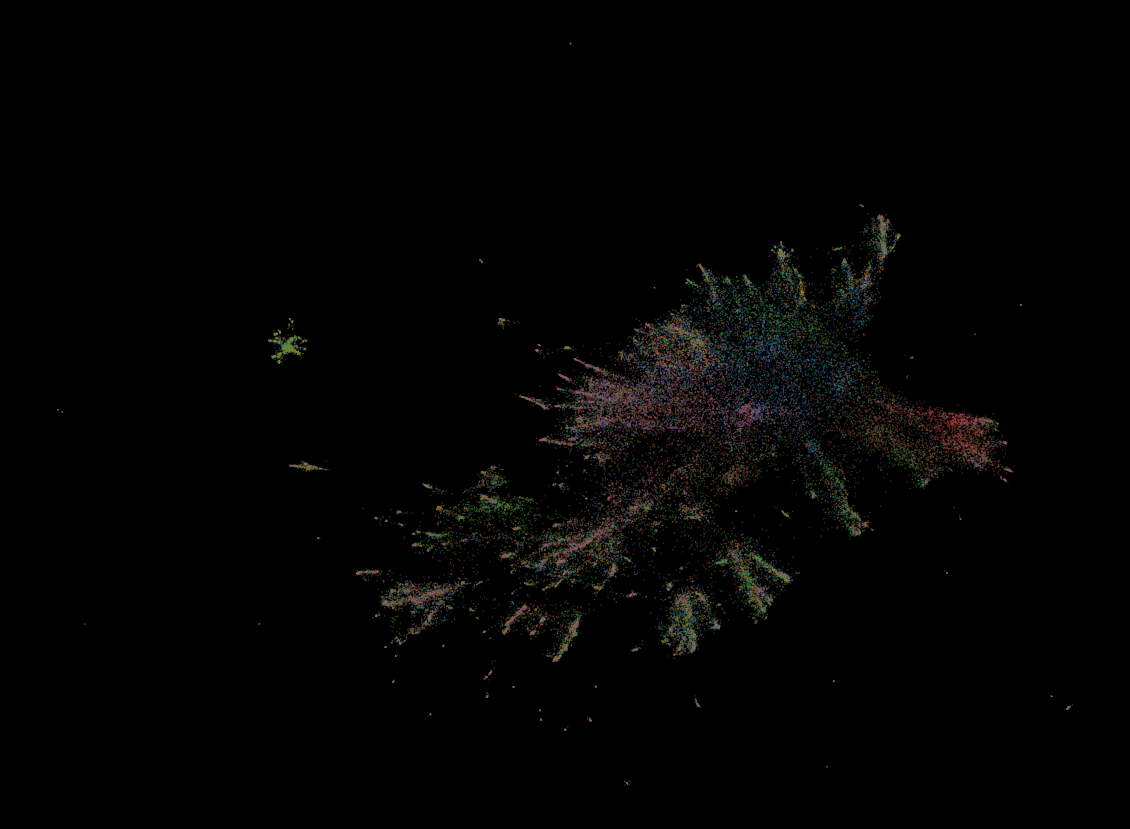

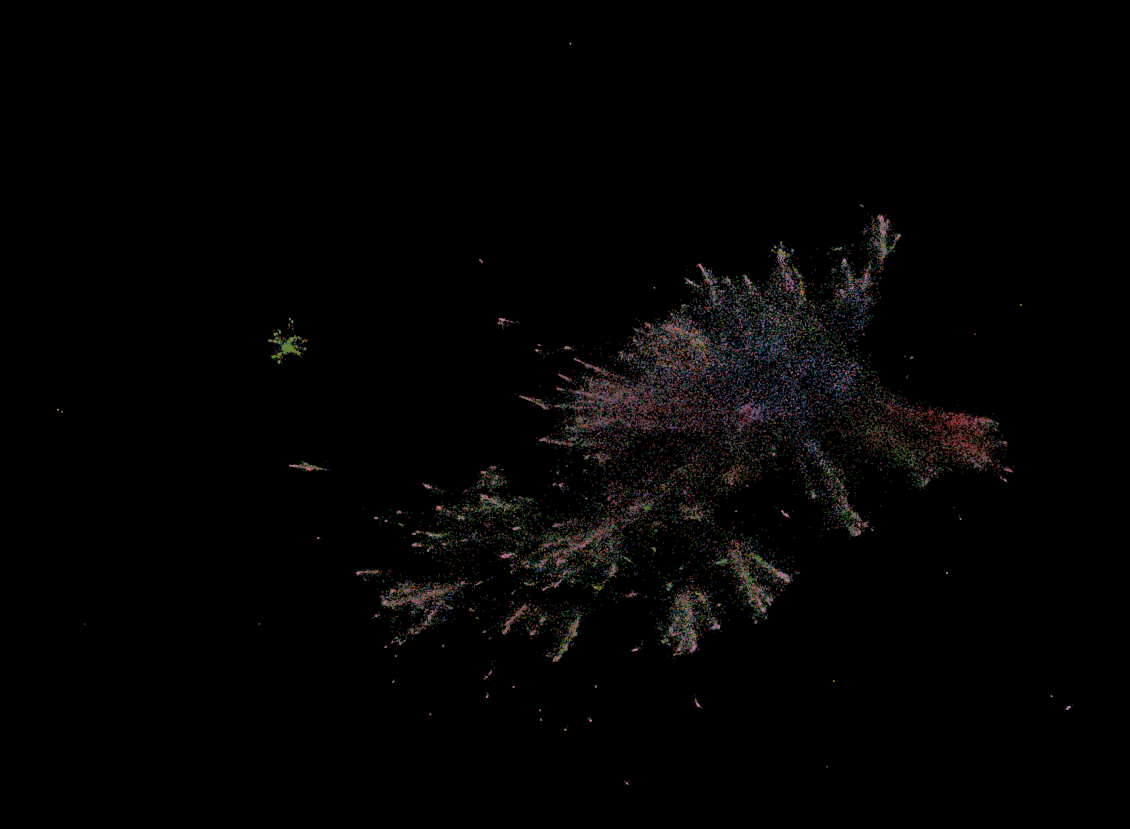

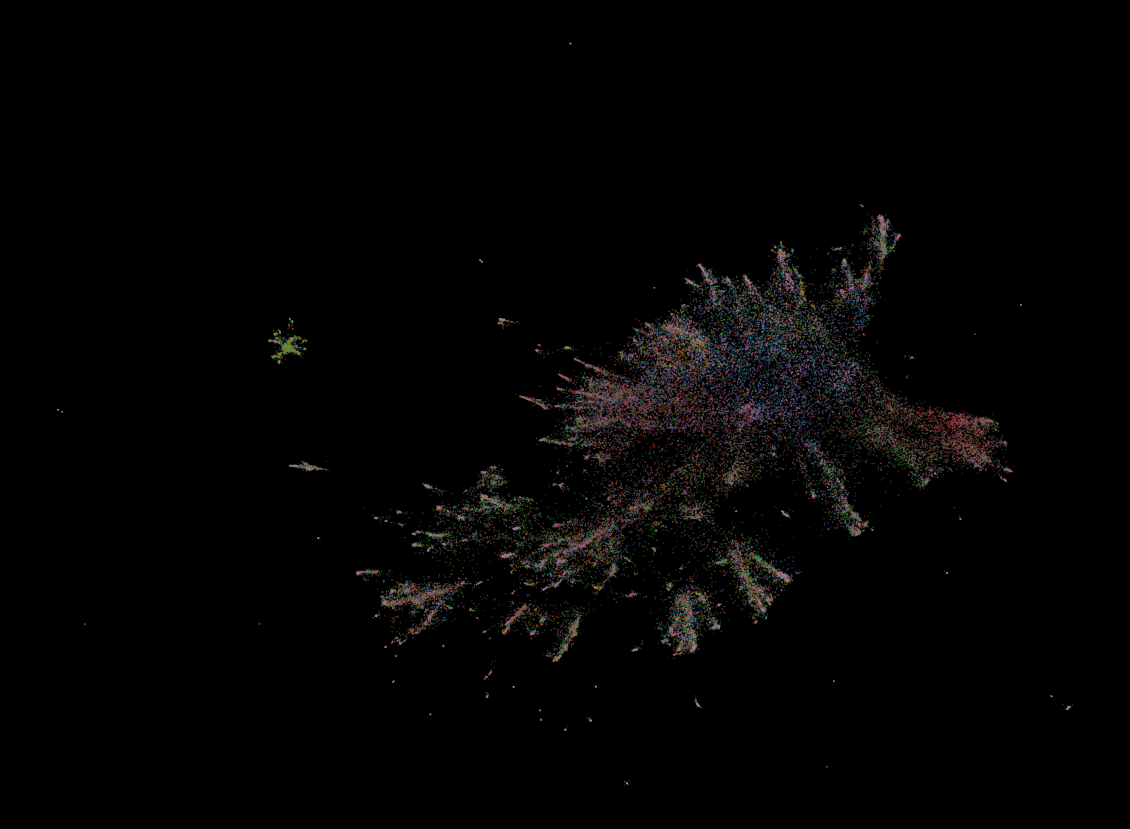

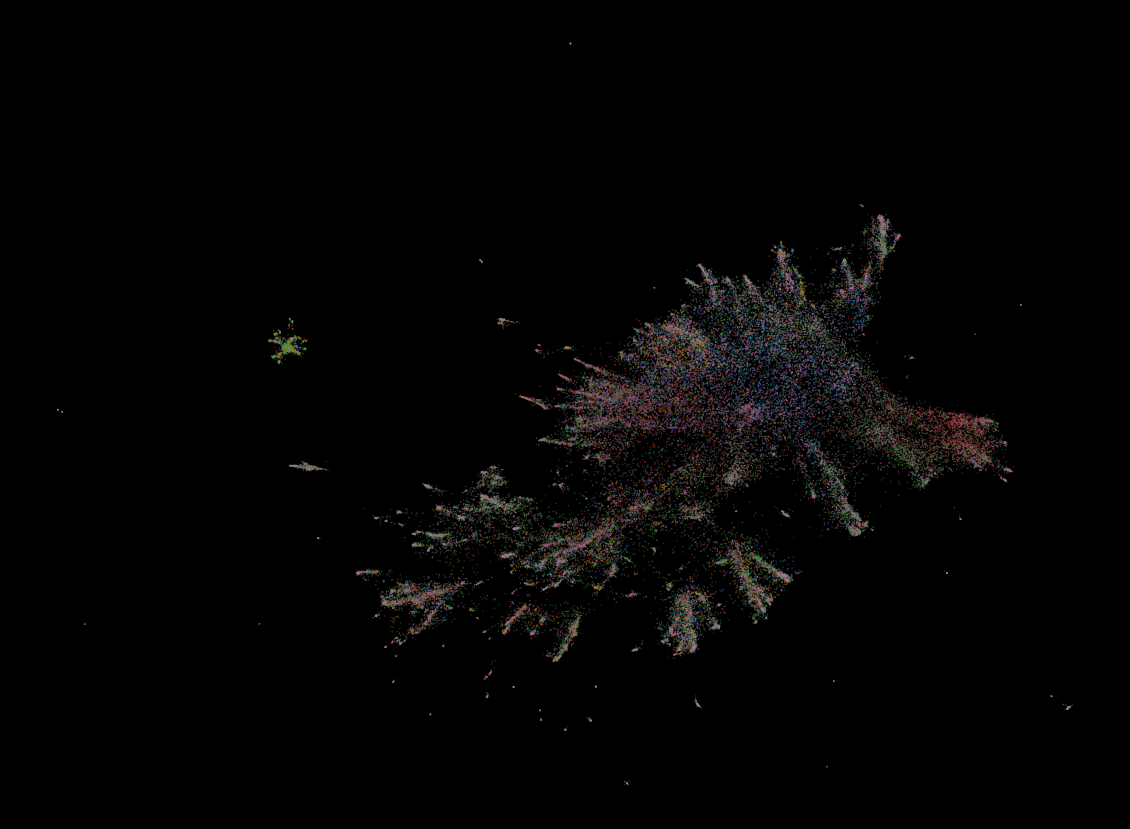

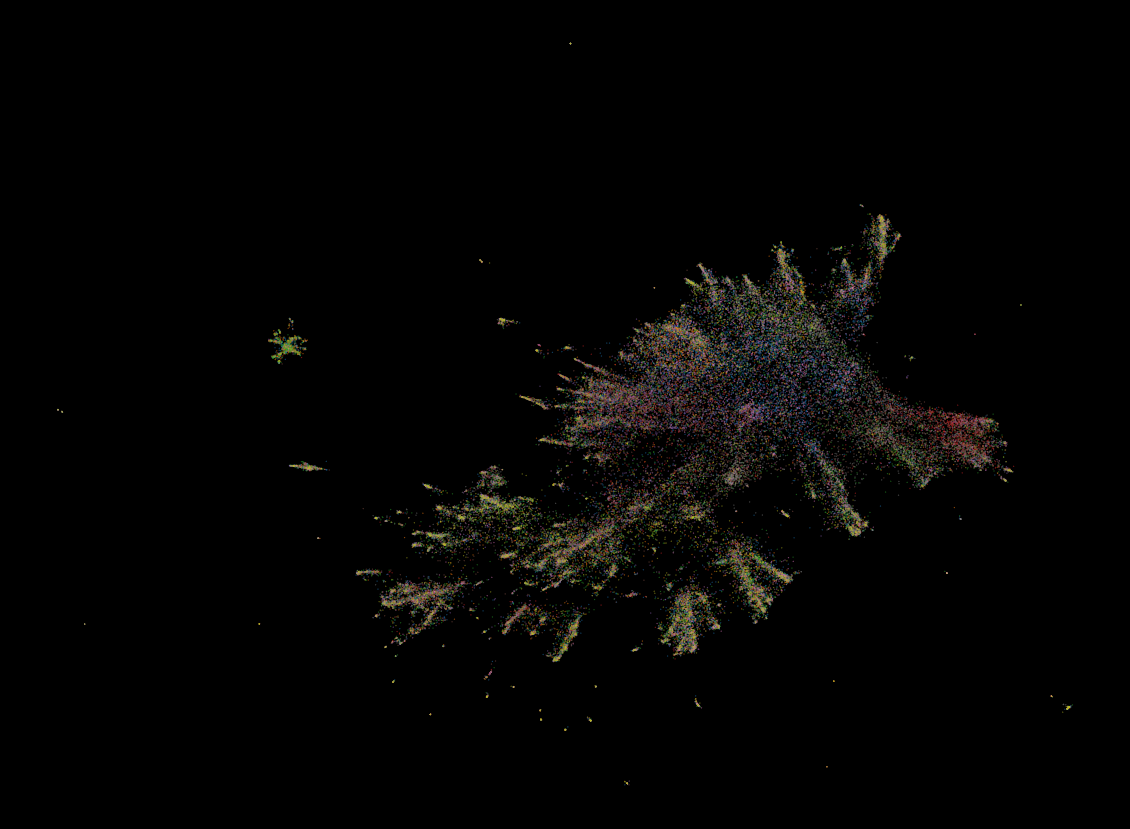

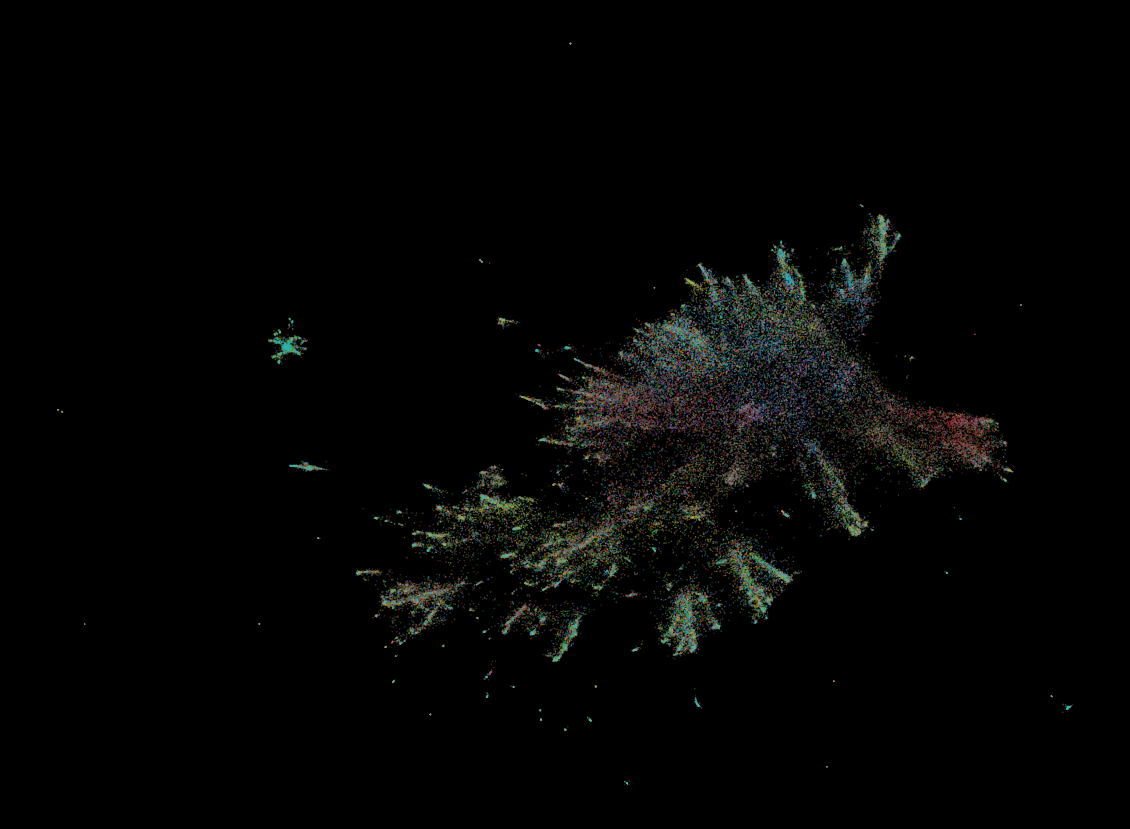

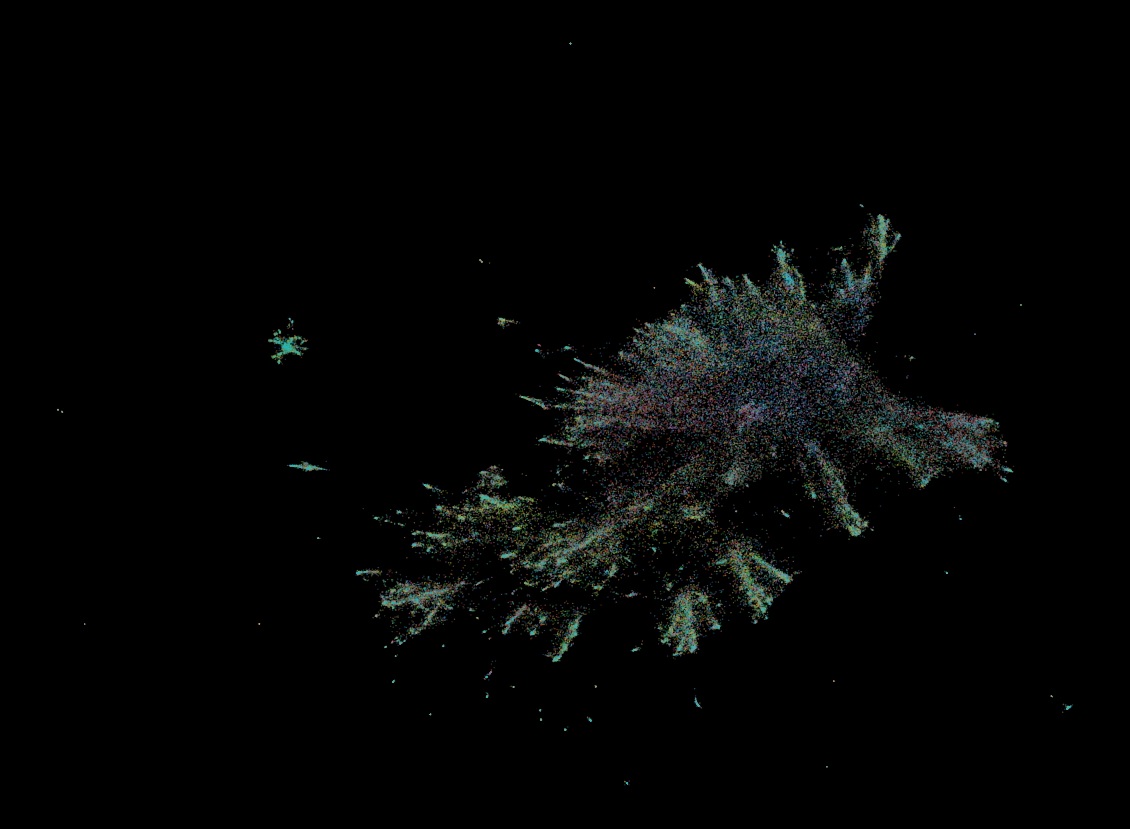

In [56]:
for i in range(1, n_topics + 1):
    fig, ax = plt.subplots(figsize=(20, 15), facecolor='black')
    ax.set_facecolor('black')
    # plt.scatter(result.x, result.y, color='fuchsia', s=0.05, cmap='tab10')

    for idx, topic in enumerate(topics[:i]):
        cluster_x = result.loc[result.labels == topic, :]
        c = [idx] * len(cluster_x)
        plt.scatter(cluster_x.x, cluster_x.y, c=c, s=0.05, cmap='tab10', vmin=0, vmax=14)

    plt.axis('off')
    plt.savefig(f"../figures/map_of_messages_lda2vec_cluster_{i}.png", bbox_inches='tight');

In [54]:
top_n = 10
topic_to_topwords = {}
for j, topic_to_word in enumerate(dat['topic_term_dists']):
    top = np.argsort(topic_to_word)[::-1][:top_n]
    msg = 'Topic %i '  % j
    top_words = [dat['vocab'][i].strip()[:35] for i in top]
    msg += ' '.join(top_words)
    print(msg)
    topic_to_topwords[j] = top_words

Topic 0 a . in looking 2 for move 1 and we
Topic 1 unit interested or in a similar tour this available .
Topic 2 in interested unit or a . units 1 bedroom more
Topic 3 the that it  ? to so does if have
Topic 4 unit interested ? this in available video or more apartment
Topic 5 to . appointment i come cancel it reschedule we see
Topic 6 to . in possible this love apartment would viewing view
Topic 7  that the just my i her insurance to did
Topic 8 this to see come tomorrow view . saturday possible i
Topic 9 month price rent 2 $ for the  . a
Topic 10  the that insurance just account pay to last my
Topic 11  the that also does rent and  of is
Topic 12 ? the included utilities is rent there what in any
Topic 13 a or in 1 2 . bedroom unit you -
Topic 14 to . i it the my but  that we


### Visualize topics

In [17]:
import warnings
warnings.filterwarnings('ignore')
prepared_data = pyLDAvis.prepare(dat['topic_term_dists'], dat['doc_topic_dists'], 
                                 dat['doc_lengths'] * 1.0, dat['vocab'], dat['term_frequency'] * 1.0, mds='tsne')

In [18]:
pyLDAvis.display(prepared_data)

Here's a summary.

Topic 1
Summary: Searching, optimistic, flexible

1. "Hi, can you please tell me a little more about this apartment. I’m looking to moving in with others and we have a dog and a cat. ..."
2. "I’m looking for 1 bed apartment with nov 1st move in. Will there be any availability around that time?"

Top words
1. Looking
2. Ideally
3. Move
4. Flexible
5. Spacious
6. Currently
7. Preference
8. Pets

Topic 2
Summary: Pandemic, employment uncertainty, anxiety

1. "Do I need to fill out any health forms prior to the open house tonight?"
2. "Hey! So, my roommate and I aren't moving till probably August due to all the COVID stuff going on ..."
3. "...about 95% of my friends and family have left NYC due to covid and loss of job so I’m looking for a sense of community within a building like this ..."
4. "Most important is my space since working from home is the new normal until mid 2021 for my company ..."
5. "... Just a little particular at this moment because of the new normal."

Top words
1. Medical
2. Job
3. Pandemic
4. Employment
5. Recently
6. But

Topic 3
Summary: Extra costs - how much more do i have to pay for shit?

1. "Are utilities included in the rent? ..."
2. "Also how much is the application fee and where can I fill it out and submit it with payment? ..."
3. "I'm currently locked out of my online banking account and can't get bank statements for proof of income. ..."

Top words
1. Pay
2. Charged
3. Security
4. Utility
5. Deposit
6. Fee
7. Rent

Topic 4
Summary: maybe section 8 related

Top words
1. Social
2. Old
3. Landlord
4. York

Topic 5
Summary: reschedule/cancel

Top words
1. Reschedule
2. Cancel
3. Sorry
4. Unable
5. Another

Topic 6
Summary: Concessions, deals, extra features, square footage

Top words
1. ?
2. Available
3. Video
4. Renovated
5. Furnished
6. Footage
7. Promotional
8. Concessions

Topic 7
Summary: Most affordable apartments

Top words
1. Curious
2. Cheapest
3. Affordable
4. Rent
5. Promotional
6. Pricing

Topic 8
Summary: Financial documents related to applying

Top words
1. Pay
2. Statements
3. Unemployment
4. Stubs
5. Discussed
6. Portal
7. Prorated

Topic 9
Summary: More application stuff

Top words
1. Application
2. Account
3. Error
4. Portal
5. Order
6. Documents
7. Electricity
8. Proceed
9. Insurance

Topic 10
Summary: Amenities and utilities plus associated costs

Top words
1. Included
2. Utilities
3. Renovated
4. Amenity
5. Washer
6. Monthly
7. Parking
8. Flooring
9. Covered
10. Cost

Topic 11
Summary: Amenity, Costs, etc

Topic 12
Summary: More application stuff bleeding into resident - paperwork

Top words
1. Keys
2. Account
3. Stubs
4. Money
5. Letter
6. Energy
7. Insurance
8. Switch
9. Forms

Topic 13
Summary: another reschedule/cancel topic, but maybe more urgent

Topic 14
Summary: schedule tour, maybe within context of specific unit or building

Top words
1. Viewing
2. Street
3. Client
4. Listing
5. Available
6. Please
7. Possible
8. Interested

Others:
1. 54th
2. Atlantic
3. Washington
4. 550
5. Kent
6. #
7. 646

Topic 15
Summary: schedule tour for specific date/time

Top words
1. Viewing
2. Schedule
3. Possible

Others:
1. 1:30
2. 11:30
3. 10:30
4. 2:30
5. Sat
6. Evening
7. Weekend

Topic 16
Summary: maybe resident/application payments

Top words
1. Liability
2. Prorated
3. Charged
4. Portal
5. Payment
6. Package
7. Pay

Topic 17
Summary: another schedule tour?

Top words
1. Viewing
2. Tomorrow
3. Possible
4. Seeing
5. See

Topic 18
Summary: Another schedule/interested

Topic 19
Summary: Apartment options and rent

Top words
1. Under
2. Units
3. More
4. Bedroom
5. Interested
6. Similiar

Others
1. 1,300
2. 1,200
3. 2500
4. 1700

Topic 20
Summary: Combo of schedule, apartment search

### Individual document topics

In [11]:
import pandas as pd
texts = pd.read_csv('../data/messages_100k.csv')['message']

In [12]:
texts.head()

0    Is the offer still available of 6 weeks free a...
1    Hi \n\nIs the b1 floor plan the knowles plan a...
2    Yes! I need to get my fathers approval. I just...
3    Looking for a studio / 1bed <$2,400, currently...
4    Hi there I’m interested in a studio\nIf I able...
Name: message, dtype: object

In [13]:
num_topics = len(dat['topic_term_dists'])

In [14]:
num_topics

20

In [15]:
dominant_doc_topics = np.argmax(dat['doc_topic_dists'], axis=1)

In [16]:
nonzero_row_indices, nonzero_col_indices = (dat['doc_topic_dists'] > 0.5).nonzero()

In [17]:
topic_texts = {}
topic_texts_idx = {}

for topic_idx in range(num_topics):
    message_idx = nonzero_row_indices[nonzero_col_indices == topic_idx]
    topic_texts[topic_idx] = texts[message_idx]
    topic_texts_idx[topic_idx] = message_idx
    if dat['doc_topic_dists'][message_idx, topic_idx].min() <= 0.5:
        print(f"Error with topic {topic_idx + 1}")
    print(len(topic_texts[topic_idx]))

5162
4301
3293
4993
5792
4225
6296
4736
4530
5841
4943
4386
5139
4498
5189
3540
2692
3175
5936
5043


In [18]:
topic_idx = 8

Topic 6

Enthusiasm

1. "I'm definitely interested in the 2 bed"
2. "I'm pleased to hear from you. Yes, I am interested in leasing out the studio/1 BR ..."
3. "...I would really like to look at the interior finishing and the view of the apartment in person...."
4. "Please contact me ASAP!"
5. "Is it too early to apply for a March 30th move in date?"
6. "Hi, I am very interested in this listing, is it still available?"
7. "Looking for a 1 bedroom for a summer move in! thanks!"
8. "Wow. That all sounds great. Could I schedule an appt to come see them?"

Topic 7

Most affordable apartments/promotions

1. "Hey Krystal. I am planning on moving intona place on August. You're promotional sounds great."
2. "...if it's possible to reduce price we can move quickly and come see the unit. Thanks"
3. "Hi! I’m a solo tenant w/ pristine tenant history + credit score, and a full-time tech job...."
4. "I wanted to find out if you have any specials going on for new residents...."
5. "I'm interested in the cheapest 2 bedroom apartments you have available...."
6. "I'm interested in the low income housing program for Axis 2300 Apartments...."
7. "Looking for a 2 bed 2 bath. Excellent credit, steady job. Looking for a great deal...."
8. "...Yes I am trying to stick to a budget<1200/month..."

Topic 8

Very similar to topic 3, topic 7

Topic 9

1. 

In [105]:
for message in topic_texts[topic_idx]:
    print(f"{message}\n======\n")

What is the price ?

Thank you

Hi,

My name is Dwizzy and I am looking for a 1 bedroom apartment under $1,000.

Could you please tell me more about:
- Total cost of moving
- Upcoming rent specials
- Price & availability

Thank you!

Hi do you have any spacious one bedrooms on a high floor available this Summer? I currently live in a similar building midtown but might move to Bklyn to save on rent.

I'm looking for a 2bed 2bath apartment and looking to move in the first week of July. I was specifically interested in A108 due to the partial Space Needle view. Are there any more units with views available or that are available in July?

Hi there, I am interested in this apartment. Curious about how the promotional pricing will shake out. Thanks! Megan

I’m interested in a 2 bedroom 2 bathroom for no more than 1,400 and I’m looking to move within the next 20 days please contact me asap with more info. Serious inquiry

8 month lease available ?

Can you send me a video tour of this apartme


Hi does this unit come with parking? What level is the unit on? Are there elevators?

Hi I'm Raymond! Are there any upcoming or ongoing rent specials?

Thanks!
Hi Yvonne - I'm interested in both the Atlas and Gotham West. Would there be availability for a showing later this afternoon? What time do the leasing offices close?

I'm interested in a Studio or 1BR, max rent $3500, for move in anywhere from now to end of March.

We are looking to move in between october or november and looking for a 1
bed 1 bath. Is it possible to view all of the 1 bed 1 bath options while
scheduling a tour?

Hi, I am interested in apartment 2 N 6th Place #8C. I am looking to move in July 1st.
Do you have a  video of this apartment ?
Let me know, thanks. Jeremie

Looking for Unit #0730, Alvarado

Yes that would work. Thank you I would like to be scheduling a tour April 25

Hello,

My name is Susan and I am looking for a 1-2 bedroom apartment under $1,000.

Could you please tell me more about:
- Scheduling a 

In [29]:
num_documents = len(dat['doc_topic_dists'])

In [106]:
num_messages_to_show = 1

topic_texts = {}
for i in range(len(dat['topic_term_dists'])):
    topic_texts[i] = texts[dominant_doc_topics == i]
    # prob = dat['doc_topic_dists'][dominant_doc_topics == i][:,i]
    # idx = np.argsort(prob)[::-1]
    print(f"Messages for topic {i + 1}:")
    for j in range(num_messages_to_show):
        print(f"{topic_texts[i].iloc[j]}\n=====\n")
    print("=====")

Messages for topic 1:
Hi, can you please tell me a little more about this apartment. I’m looking to moving in with others and we have a dog and a cat. The dog is a Rottweiler mix. Please let me know! Thank you!
=====

=====
Messages for topic 2:
Dear leasing Officer,

My name is Dibash Sapkota. I am looking for 1bedroom apartment for me and
my wife starting from 11th April. I was in the leasing office this
afternoon but seems like you guys are closed. It would be great if I could
get further information about availability and rent. Also I was wondering
if you can arrange time for me to have the tour of the unit so I could
decide on moving ASAP. One of my friend (current resident of your
apartment) referred you to me.

Looking forward to hearing from you.
=====

=====
Messages for topic 3:
Hello I tried to make a appointment thru the link you sent and it says
there are no available appointments
=====

=====
Messages for topic 4:
Hi, I'm Kari. I am interested in Unit 22-111 or units with

#### First Example

In [32]:
print(texts[0])

Is the offer still available of 6 weeks free and 5% off?


In [49]:
msg = "{weight:02d}% in topic {topic_id:02d} which has top words {text:s}"
for topic_id, weight in enumerate(dat['doc_topic_dists'][0]):
    if weight > 0.01:
        text = ', '.join(topic_to_topwords[topic_id])
        print(msg.format(topic_id=topic_id, weight=int(weight * 100.0), text=text))

99% in topic 10 which has top words the, , , rent, how, have, what, do, that, ?


<BarContainer object of 20 artists>

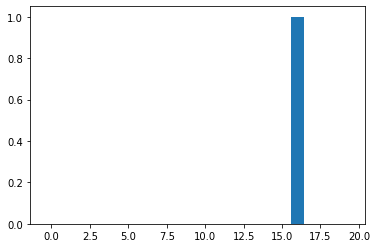

In [50]:
plt.bar(np.arange(20), dat['doc_topic_dists'][1])

#### Second Example

In [43]:
print(texts[3])

Looking for a studio / 1bed <$2,400, currently located in Nob Hill and open to different neighborhoods in the city (minus downtown / tenderloin, maybe soma) . Thanks!


In [44]:
msg = "{weight:02d}% in topic {topic_id:02d} which has top words {text:s}"
for topic_id, weight in enumerate(dat['doc_topic_dists'][3]):
    if weight > 0.01:
        text = ', '.join(topic_to_topwords[topic_id])
        print(msg.format(topic_id=topic_id, weight=int(weight * 100.0), text=text))

99% in topic 06 which has top words in, looking, ., and, for, a, the, move, , ,


<BarContainer object of 20 artists>

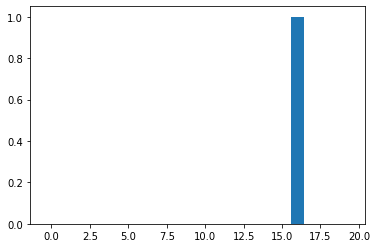

In [45]:
plt.bar(np.arange(20), dat['doc_topic_dists'][1])